# Examples

In [5]:
from concurrent.futures import ThreadPoolExecutor
import dask
import dask.array as da
from dask.distributed import Client
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import scipy.signal as ss
import time
from tqdm.auto import tqdm

d:\CSM\Mines_Research\Repositories\exploring_dask\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set-up an example with matrix-vector multiplication followed by an addition to a vector (SAXPY)

In [6]:
# create a vector of 1000 elements
n = 10000
n_chunks = 10
x = da.random.random(n, chunks=n/n_chunks)
b = da.random.random(n, chunks=n/n_chunks)
# create a matrix of nxn elements
A = da.random.random((n, n), chunks=(n/n_chunks, n/n_chunks))
a = 5.5
y = A @ x + b

Explore the performance for applying compute() in different ways.

In [7]:
n_reps = 5
strt = time.time()
for i in range(n_reps):
    # y.compute(schedule='single-threaded')
    # y.compute()
    y.compute(num_workers=10)
    # with dask.config.set(pool=ThreadPoolExecutor(2)):
        # y.compute()
end = time.time()
print("Total Time taken for computation: ", end-strt, " seconds")
print("Time taken for computation: ", (end-strt)/n_reps, " seconds")

Total Time taken for computation:  1.5691955089569092  seconds
Time taken for computation:  0.31383910179138186  seconds


We can do a scalability test to see how our performance scales with the number of threads.

In [59]:
threads = [1, 2, 4, 5, 10, 12]
ns = [100, 1000, 10000, 100000] # , 1000000, 10000000, 100000000]
times = np.zeros((len(ns), len(threads)+1))
# times = []
reps = 10


for k in range(len(ns)):
    n = ns[k]
    x = da.random.random(n, chunks=n/n_chunks)
    b = da.random.random(n, chunks=n/n_chunks)
    A = da.random.random((n, n), chunks=(n/n_chunks, n/n_chunks))
    y = A @ x + b

    strt = time.time()
    for j in range(reps):
        y.compute(schedule='single-threaded')
    end = time.time()
    times[k,0] = ((end-strt)/reps)
    print("Total Time taken for computation with single-threaded: ", end-strt, " seconds")

    for ii in tqdm(range(len(threads))):
        i = threads[ii]
        strt = time.time()
        for j in range(reps):
            with dask.config.set(pool=ThreadPoolExecutor(i)):
                y.compute()
        end = time.time()
        times[k,ii+1] = ((end-strt)/reps)
        print("Total Time taken for n= ", n, " computation with ", i, " threads: ", end-strt, " seconds")


Total Time taken for computation with single-threaded:  0.6569957733154297  seconds
Total Time taken for n=  100  computation with  1  threads:  0.7310025691986084  seconds
Total Time taken for n=  100  computation with  2  threads:  0.7019979953765869  seconds
Total Time taken for n=  100  computation with  4  threads:  0.6510002613067627  seconds
Total Time taken for n=  100  computation with  5  threads:  0.6429994106292725  seconds
Total Time taken for n=  100  computation with  10  threads:  0.6410026550292969  seconds
Total Time taken for n=  100  computation with  12  threads:  0.7570011615753174  seconds
Total Time taken for computation with single-threaded:  0.8528106212615967  seconds
Total Time taken for n=  1000  computation with  1  threads:  0.9229996204376221  seconds
Total Time taken for n=  1000  computation with  2  threads:  0.8690011501312256  seconds
Total Time taken for n=  1000  computation with  4  threads:  0.8859975337982178  seconds
Total Time taken for n=  1

Plotting the results of our scalability test. The first point on each curve is the performance of the serial code, and the rest of the points are the performance of the parallel code with different numbers of threads. 

The effect of the overhead of parallelization can be seen by comparing the performance of the parallel code with one thread to the serial code. This overhead lessens as the number of threads and array size increases.

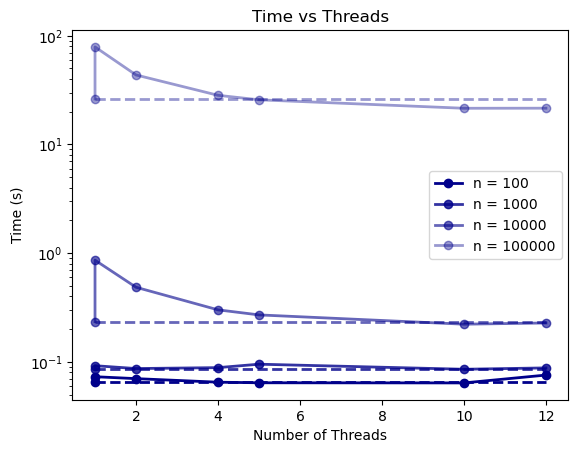

In [60]:
for i in range(len(ns)):
    plt.plot([1] + threads, times[i,:], 'o-',color='darkblue',label='n = '+str(ns[i]),alpha=1-0.2*i, linewidth=2)
    plt.plot([1,12], [times[i,0],times[i,0]] , '--',color='darkblue',alpha=1-0.2*i, linewidth=2)

plt.xlabel('Number of Threads')
plt.ylabel('Time (s)')
plt.title('Time vs Threads')
plt.yscale('log')
plt.legend()

Next, we can look at the effect on performance of different number of blocks for the same array size.

In [61]:
threads = [1, 2, 4, 5, 10, 12]
n = 10000
nblocks = [5, 10, 20, 50, 100, 1000]
b_times = np.zeros((len(nblocks), len(threads)+1))
# times = []
reps = 10


for k in tqdm(range(len(nblocks))):
    n_chunks = nblocks[k]
    x = da.random.random(n, chunks=n/n_chunks)
    b = da.random.random(n, chunks=n/n_chunks)
    A = da.random.random((n, n), chunks=(n/n_chunks, n/n_chunks))
    y = A @ x + b

    strt = time.time()
    for j in range(reps):
        y.compute(schedule='single-threaded')
    end = time.time()
    b_times[k,0] = ((end-strt)/reps)
    print("Total Time taken for computation with single-threaded: ", end-strt, " seconds")

    for ii in range(len(threads)):
        i = threads[ii]
        strt = time.time()
        for j in range(reps):
            with dask.config.set(pool=ThreadPoolExecutor(i)):
                y.compute()
        end = time.time()
        b_times[k,ii+1] = ((end-strt)/reps)
        print("Total Time taken for computation with ", i, " threads: ", end-strt, " seconds")

Total Time taken for computation with single-threaded:  2.3430140018463135  seconds
Total Time taken for computation with  1  threads:  8.73531436920166  seconds
Total Time taken for computation with  2  threads:  5.247344493865967  seconds
Total Time taken for computation with  4  threads:  3.233957529067993  seconds
Total Time taken for computation with  5  threads:  2.9210267066955566  seconds
Total Time taken for computation with  10  threads:  2.486001968383789  seconds
Total Time taken for computation with  12  threads:  2.352997064590454  seconds
Total Time taken for computation with single-threaded:  2.4420011043548584  seconds
Total Time taken for computation with  1  threads:  9.352316856384277  seconds
Total Time taken for computation with  2  threads:  5.143260717391968  seconds
Total Time taken for computation with  4  threads:  3.1832404136657715  seconds
Total Time taken for computation with  5  threads:  2.9407644271850586  seconds
Total Time taken for computation with 

The plot shows that the performance is best when there is lower number of blocks. This is likely because the overhead of parallelization is less when there are fewer blocks.

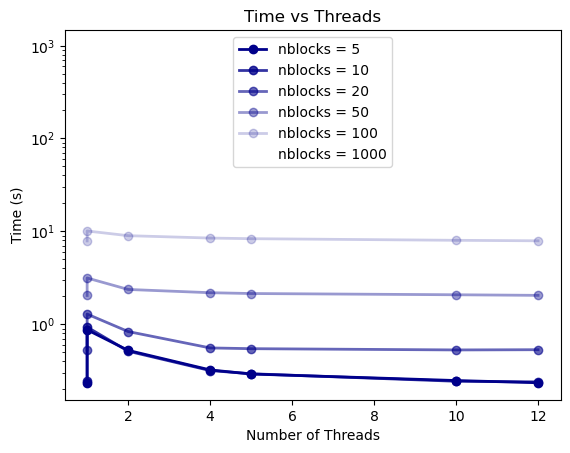

In [76]:
for i in range(len(nblocks)):
    plt.plot([1] + threads, b_times[i,:], 'o-',color='darkblue',label='nblocks = '+str(nblocks[i]),alpha=1-0.2*i, linewidth=2)
    # plt.plot([1] + threads, np.log(b_times[i,:]), 'o-',color='darkblue',label='nblocks = '+str(nblocks[i]),alpha=1-0.2*i, linewidth=2)

plt.xlabel('Number of Threads')
plt.ylabel('Time (s)')
plt.title('Time vs Threads')
plt.legend()
plt.yscale('log')

The different lines over here refer to computation times for different number of blocks in matrices and vectors of the same dimensions. Matrix dimensions are 10000x10000 and vector dimensions are 10000x1.

## Overlapping Computations

Some parallel implementations require data from blocks of data being handled by other threads. The areas that need to be communicated are called "halos" or "ghost regions". This is a common pattern in stencil computations, where each cell is updated based on the values of its neighbors. One way dask handles this pattern is by using the `map_overlap` method. This function applies a function to each block of data, but also includes a buffer of data from neighboring blocks. This allows the function to access the neighboring data without needing to communicate it explicitly.

The first input to `map_overlap` is the function we wish to apply. The next couple of inputs are inputs to the "input function", these are the inputs that the function will receive. Among the other inputs are `depth` which is the number of entries to communicate from each side of the block, and `boundary` which is the value to use for the buffer when the block is on the edge of the array and takes the value ‘reflect’, ‘periodic’, ‘nearest’, ‘none’, or any constant value like 0 or np.nan. The can be dicts or tuples to indicate different depths and boundary conditions for different dimensions. The use of these can be seen in the examples below.

In [8]:
x = np.array([1, 1, 2, 3, 3, 3, 2, 1, 1])
x = da.from_array(x, chunks=5)
def derivative(x):
    return x - np.roll(x, 1)

y = x.map_overlap(derivative, depth=1, boundary=0)
y.compute()

array([ 1,  0,  1,  1,  0,  0, -1, -1,  0])

In this example, we have two 1-d blocks of length 5, and we want to compute the sum of each element with its neighbors. We can use `map_overlap` to compute the sum of each element with its neighbors, and then sum the results to get the final result. The `depth` parameter is set to 1, so that each block communicates one element from each side. The `boundary` parameter is set to 0, so that the buffer is filled with zeros when the block is on the edge of the array. So for the first block, we have the following computation:
```
[1, 1, 2, 3, 3] -> [0, 1, 1, 2, 3, 3, 3] - [3, 0, 1, 1, 2, 3, 3]-> [-3, 1, 0, 1, 1, 0, 0]
```
This gets trimmed to `[1, 0, 1, 1, 0]` since the trim defaults to true. This removes entries created due to the boundary condition and overlap. The second block is computed similarly given `[0, 0, 1, 1, 0, 1]` which is trimmed to `[0, -1, -1, 0]`. The final result is the concatenation of the two blocks.

Another way to acheive this is by using the `map_blocks` method. This method only applies the function to  the blocks of data, and does not include any overlap. However, there exists an `overlap` function that can be used to add the overlap to the blocks of data before applying the function. The extra points introduced due to the overlap can then be removed by the `trim_internal` method. 

In [9]:
x2 = da.overlap.overlap(x, depth=1, boundary=0)
y = x2.map_blocks(derivative)
y.compute()
da.overlap.trim_internal(y,{0:1}, boundary=0).compute()

array([ 1,  0,  1,  1,  0,  0, -1, -1,  0])

Next is an example with 2-d data. This shows how we can handle the depth and boundary separately for each dimension. For the first block, we have the following computation:
```
[[0, 1], [4, 5]] -> [[0, 1, 2], [0, 1, 2], [4, 5, 6], [8, 9, 10]] + 12 -> [[12, 13, 14], [12, 13, 14], [16, 17, 18], [20, 21, 22]]
```
Again, the `trim` parameter is set to true, so the result is trimmed to `[[12, 13], [16, 17]]`. THe other blocks then make up the rest of the result.

In [10]:
x = np.arange(16).reshape((4, 4))
d = da.from_array(x, chunks=(2, 2))

func = lambda x: x + x.size
depth = {0: 1, 1: 1}
boundary = {0: 'reflect', 1: 'none'}
d.map_overlap(func, depth, boundary).compute()  

array([[12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27]])

The `map_overlap` function can take functions with more than one input. However, the entries all need to be `dask.array` objects with chunks that can "broadcast together". For example, the following code will work:

In [161]:
func = lambda x, y: x + y
x = da.arange(8).reshape(2, 4).rechunk((1, 2))
y = da.arange(4).rechunk(2)
da.map_overlap(func, x, y, depth=1, boundary='reflect').compute() 

array([[ 0,  2,  4,  6],
       [ 4,  6,  8, 10]])

For functions with inputs that are not `dask.array` objects, the `map_blocks`, `overlap`, and`trim_internal` functions combinations may be used. The next example illustrates this.

### STA/LTA

The Short Term Average to Long Term Average (STA/LTA) is a simple algorithm to detect seismic events. It is based on the ratio of the short term average to the long term average of the signal. The STA/LTA ratio is computed for each sample of the signal. When the ratio exceeds a certain threshold, a seismic event is detected.

This example covers two cases:
- Overlapping computations with functions that takes other inputs that are not dask arrays.
- Overlapping computations with unsymmetric ghost regions.

In [102]:
def stalta_freq(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    if data.ndim == 1:
        longtime_avg = ss.correlate(np.absolute(data), np.ones(len_lt), mode = "valid")
        shorttime_avg = ss.correlate(np.absolute(data[(len_lt - len_st):]), np.ones(len_st), mode = "valid")
        stalta = (shorttime_avg * len_lt)/(longtime_avg * len_st)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        stalta = np.empty((nch, nsamples - len_lt + 1), dtype=np.float64)
        longtime_stencil = np.ones(int(len_lt))
        shorttime_stencil = np.ones(int(len_st))
        for a in range(nch):
            longtime_avg = ss.correlate(np.absolute(data[a]), longtime_stencil, mode = "valid")
            shorttime_avg = ss.correlate(np.absolute(data[a, int(len_lt - len_st):]), shorttime_stencil, mode = "valid")
            stalta[a] = (shorttime_avg * len_lt)/(longtime_avg * len_st)

    return stalta


def stalta_time(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    if data.ndim == 1:
        result = np.empty(len(data) - len_lt + 1)
        ltr_sum = sum(np.absolute(data[:len_lt]))
        str_sum = sum(np.absolute(data[len_lt - len_st : len_lt]))
        for a in range(len(result)):
            if a < len(data) - 1:
                result[a] = (str_sum / len_st) / (
                    ltr_sum / len_lt
                )
                ltr_sum = (
                    ltr_sum + np.absolute(data[a + 1]) - np.absolute(data[a + 1 - len_lt])
                )
                str_sum = (
                    str_sum + np.absolute(data[a + 1]) - np.absolute(data[a + 1 - len_st])
                )
            else:
                result[a] = (str_sum / len_st) / (ltr_sum / len_lt)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        result = np.empty((nch, nsamples - len_lt + 1))
        ltr_sum = np.sum(np.absolute(data[:, :len_lt]), axis = 1)
        str_sum = np.sum(np.absolute(data[:, len_lt - len_st : len_lt]), axis = 1)
        for a in range(len_lt-1, nsamples):
            if a < nsamples - 1:
                result[:, a - len_lt + 1] = (str_sum / len_st) / (
                    ltr_sum / len_lt
                )
                ltr_sum = (
                    ltr_sum + np.absolute(data[:, a + 1]) - np.absolute(data[:, a + 1 - len_lt])
                )
                str_sum = (
                    str_sum + np.absolute(data[:, a + 1]) - np.absolute(data[:, a + 1 - len_st])
                )
            else:
                result[:, a - len_lt + 1] = (str_sum / len_st) / (ltr_sum / len_lt)
    return result

Set-up random data for the example:

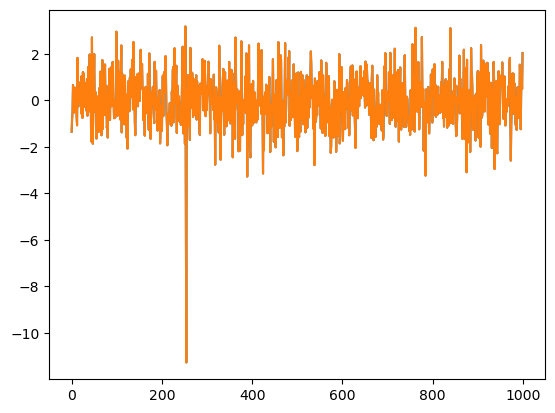

In [60]:
sig_len = 1000
rng = np.random.default_rng()
np_signal = rng.standard_normal(sig_len)
np_signal[int(sig_len/4):int(sig_len/4)+5] = np_signal[int(sig_len/4):int(sig_len/4)+5] * 5
da_signal = da.from_array(np_signal, chunks=100)

plt.plot(da_signal.compute())
plt.plot(np_signal)

Set up the STA/LTA parameters and the computation in parallel using `overlap` and `map_blocks`. The `overlap` function is used to add the overlap to the blocks of data before applying the function. The extra points introduced due to the overlap can then be removed by the `trim_internal` method.

951 951 933


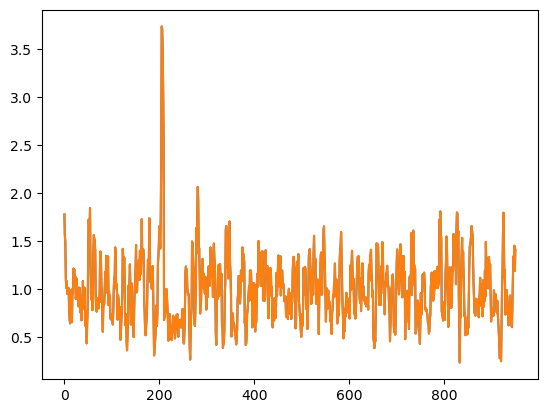

In [153]:
len_lt = 50
len_st = 5
np_detection = stalta_freq(np_signal, len_lt, len_st) # computation with numpy for comparison
da_detection = stalta_freq(da_signal, len_lt, len_st) # Naive computation with dask array. Not sure if parallelization actually happens

# dask implementation with overlap and map_blocks. trim_internal is not used since communicated zones is exact.
x2 = da.overlap.overlap(da_signal, depth={0:(int(len_lt/2-1), int(len_lt/2))}, boundary=None)
y = x2.map_blocks(stalta_freq, len_lt, len_st, dtype=np.float64)   

plt.plot(np_detection)
# plt.plot(da_detection)
# plt.plot(da.overlap.trim_internal(y,{0:1},boundary=None).compute())
plt.plot(y.compute())
# plt.plot(da.map_blocks(stalta_freq, da_signal, len_lt, len_st,dtype=np.float64).compute())
print(len(np_detection),len(y.compute()), len(da.overlap.trim_internal(y,{0:1},boundary=None).compute()))

## Game of Life

Implemented the game of life using dask. Might have gotten too carried away with the game itself and didn't focus on the parallelization part.

In [11]:
def neighbor_sum(array: np.array, row_index: int, column_index: int) -> int:
    '''Returns the sum of the 8 neighbors of the element at row_index, column_index.
    Input:
    array: 2D numpy array
    row_index: int
    column_index: int
    Output:
    sum of neighbor: int
    '''
    row_size, column_size = array.shape
    row_left = max(0,row_index-1)
    row_right = min(row_index+2, row_size)
    col_up = max(0,column_index-1)
    col_down = min(column_index+2, column_size)
    
    neighborhood = array[row_left:row_right, col_up:col_down]

    return np.sum(neighborhood) - array[row_index, column_index]

def life_epoch(array: np.array) -> np.array:
    '''Returns the next state of the array according to the rules of Conway's Game of Life.
    Input:
    array: 2D numpy array
    Output:
    next state: 2D numpy array
    '''
    row_size, column_size = array.shape
    next_state = da.zeros((row_size, column_size))
    for i in range(row_size):
        for j in range(column_size):
            neighbors = neighbor_sum(array, i, j)
            if neighbors == 3:
                next_state[i,j] = 1
            elif array[i,j] == 1 and neighbors == 2:
                next_state[i,j] = 1

    return next_state

def initiate_life(row_size: int, column_size: int, prob: float) -> np.array:
    '''Returns a random 2D array of size row_size x column_size with prob probability of 1s.
    Input:
    row_size: int
    column_size: int
    prob: float
    Output:
    2D numpy array
    '''
    return np.random.choice([0, 1], size=(row_size, column_size), p=[1-prob, prob])

In [12]:
array = np.array([[1,2,3],[4,5,6],[7,8,9]])
data = da.from_array(array, chunks=(2,2))
row_index = 1
column_index = 1
# print(neighbor_sum(array, row_index, column_index))
print(neighbor_sum(data, row_index, column_index).compute())
da.empty_like(data).compute()

40


array([[12, 12,  9],
       [12, 12,  9],
       [15, 15,  9]])

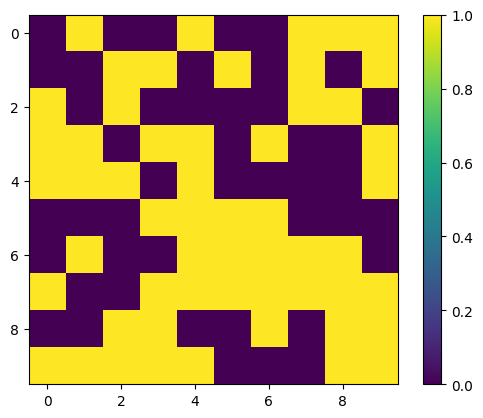

In [13]:
life = initiate_life(10,10,0.5)
life = da.from_array(life, chunks=(5,5))
plt.imshow(life.compute())
plt.colorbar()

100%|██████████| 50/50 [38:54<00:00, 46.69s/it]


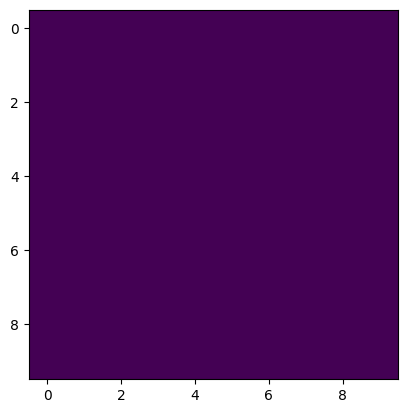

In [14]:
# display video of life
fig = plt.figure()
ims = []
for i in tqdm(range(50)):
    # life = life_epoch(life)
    life = da.map_overlap(life_epoch, life, depth=1, boundary=0)
    im = plt.imshow(life.compute(), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
display(HTML(ani.to_jshtml()))

Rerun with a larger array.

  0%|          | 0/50 [00:00<?, ?it/s]

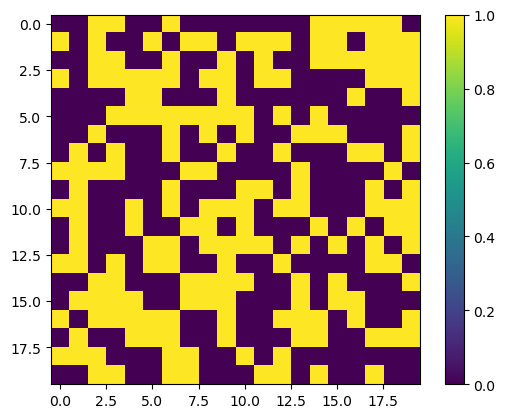

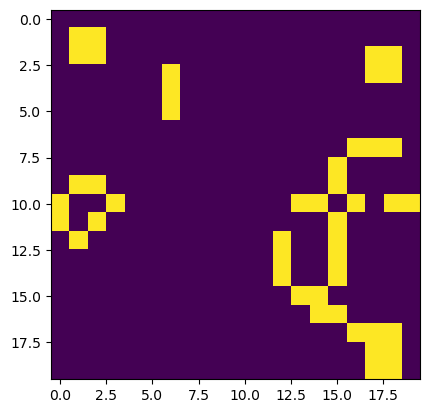

In [41]:
life = initiate_life(20,20,0.5)
life = da.from_array(life, chunks=(5,5))
plt.imshow(life.compute())
plt.colorbar()
# display video of life

fig = plt.figure()
ims1 = []
for i in tqdm(range(50)):
    # life = life_epoch(life)
    life = da.map_overlap(life_epoch, life, depth=1, boundary=0)
    im = plt.imshow(life.compute(), animated=True)
    ims1.append([im])

ani1 = animation.ArtistAnimation(fig, ims1, interval=200, blit=True, repeat_delay=1000)
display(HTML(ani1.to_jshtml()))